### PPO with Bayesian Optimization

In [1]:
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split
import h5py
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import json

In [ ]:
# Data Preprocessing Function

def preprocess_data(df):
    # Derive occupancy from lights (1 if lights > 0, else 0).
    df['Occupancy'] = df['lights'].apply(lambda x: 1 if x > 0 else 0)
    
    # Compute the average indoor temperature from columns T1 to T9.
    temp_cols = [f'T{i}' for i in range(1, 10)]
    df['Avg_T1_T9'] = df[temp_cols].mean(axis=1)
    
    # Compute HVAC energy consumption (Appliances minus lights).
    df['HVAC_energy'] = df['Appliances'] - df['lights']
    
    # Extract hour of day from the date column.
    df['date'] = pd.to_datetime(df['date'])
    df['Hour_of_day'] = df['date'].dt.hour
    
    # Select only the relevant features.
    relevant_features = ['Avg_T1_T9', 'T_out', 'Occupancy', 'Hour_of_day', 'HVAC_energy']
    df = df[relevant_features].copy()
    
    # Forward-fill any missing values.
    df.ffill(inplace=True)
    return df

In [ ]:
# HVAC Environment with Dynamic Temperature and Scaled Reward

class HVACEnvironment:
    def __init__(self, dataframe, desired_temperature=22):
        self.df = dataframe.copy()
        self.desired_temperature = desired_temperature  
        self.observation_space_shape = self.df.shape[1]  # number of features
        self.action_space_n = 4  # 0 = Off, 1 = Low, 2 = Medium, 3 = High
        self.current_step = 0
        self.max_steps = len(self.df) - 1
        
        # Determine energy thresholds (for simulation purposes)
        self.energy_thresholds = {
            'Low': self.df['HVAC_energy'].quantile(0.25),
            'Medium': self.df['HVAC_energy'].quantile(0.5),
            'High': self.df['HVAC_energy'].quantile(0.75)
        }
        # Initialize a mutable indoor temperature.
        self.current_temp = self.df['Avg_T1_T9'].iloc[0]

    def reset(self, start_step=0):
        self.current_step = start_step
        # Reset the indoor temperature.
        self.current_temp = self.df['Avg_T1_T9'].iloc[self.current_step]
        return self._get_state()

    def _get_state(self):
        # Use the updated current_temp in place of the fixed dataset value.
        row = self.df.iloc[self.current_step].copy()
        row['Avg_T1_T9'] = self.current_temp
        return row.values

    def _get_reward(self, action, simulated_energy):
        # Scale the reward (divide by 1000) for numerical stability.
        lambda_factor = 0.9
        reward = -(simulated_energy + lambda_factor * abs(self.current_temp - self.desired_temperature)) / 1000.0
        return reward

    def _take_action(self, action):
        # Simulate HVAC energy consumption based on the chosen action.
        if action == 0:  # Off
            hvac_energy = np.random.uniform(0, 25)
        elif action == 1:  # Low
            hvac_energy = np.random.uniform(25, 100)
        elif action == 2:  # Medium
            hvac_energy = np.random.uniform(100, 300)
        elif action == 3:  # High
            hvac_energy = np.random.uniform(300, 500)
        else:
            raise ValueError("Invalid action.")
        return hvac_energy

    def step(self, action):
        simulated_energy = self._take_action(action)
        # Update the indoor temperature using a simple dynamics model.
        temp_change = (self.desired_temperature - self.current_temp) * 0.05
        self.current_temp += temp_change * (simulated_energy / 500.0)
        
        self.current_step += 1
        next_state = self._get_state()
        reward = self._get_reward(action, simulated_energy)
        done = self.current_step >= self.max_steps
        return next_state, reward, done, {"HVAC_energy": simulated_energy}

In [ ]:
# Actor and Critic Networks for PPO

class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        self.dropout = nn.Dropout(p=0.2)  # Dropout with 20% probability
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first layer
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the second layer
        logits = self.fc3(x)
        return logits

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.2)  # Dropout with 20% probability
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first layer
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after the second layer
        value = self.fc3(x)
        return value

In [ ]:
# PPO Agent 

class PPOAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        # PPO hyperparameters.
        self.clip_epsilon = 0.2
        self.gamma = 0.99
        self.lamda = 0.95  # GAE lambda
        self.actor_lr = 1e-4
        self.critic_lr = 1e-3
        self.update_epochs = 4
        self.mini_batch_size = 64

        self.actor = Actor(state_size, action_size).to(device)
        self.critic = Critic(state_size).to(device)
        # self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_lr)
        # self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.actor_lr, weight_decay=1e-4)  # L2 regularization
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.critic_lr, weight_decay=1e-4)

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).to(self.device)
        logits = self.actor(state_tensor)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state_tensor)
        return action.item(), log_prob.item(), value.item()

In [ ]:
# Compute Returns and Advantages (GAE)

def compute_gae(rewards, dones, values, gamma, lamda):
    advantages = []
    gae = 0
    # Append an extra value for ease (assume terminal state has 0 value)
    values = values + [0]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lamda * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    returns = [adv + val for adv, val in zip(advantages, values[:-1])]
    return returns, advantages

In [7]:
def train_ppo(env, agent, val_env, n_episodes=1000, max_t=500, cost_factor=0.10, patience=100):
    episode_rewards = []
    episode_losses = []
    entropy_vals = []
    overall_start_time = time.time()

    best_val_reward = -float('inf')  # Track the best validation reward
    no_improvement_count = 0  # Counter for early stopping

    for episode in range(n_episodes):
        ep_start_time = time.time()
        states, actions, log_probs, rewards, dones, values = [], [], [], [], [], []
        baseline_energy_sum, rl_energy_sum, temp_deviation_sum = 0.0, 0.0, 0.0

        state = env.reset()
        total_reward = 0

        for t in range(max_t):
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)

            action, log_prob, value = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            rl_energy_sum += info.get("HVAC_energy", 0.0)
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            dones.append(1 if done else 0)
            values.append(value)

            total_reward += reward
            state = next_state
            if done:
                break

        returns, advantages = compute_gae(rewards, dones, values, agent.gamma, agent.lamda)
        states_tensor = torch.FloatTensor(np.array(states)).to(agent.device)
        actions_tensor = torch.LongTensor(actions).to(agent.device)
        old_log_probs_tensor = torch.FloatTensor(log_probs).to(agent.device)
        returns_tensor = torch.FloatTensor(returns).to(agent.device)
        advantages_tensor = torch.FloatTensor(advantages).to(agent.device)
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

        losses, episode_entropy = [], []
        dataset_size = states_tensor.size(0)
        for _ in range(agent.update_epochs):
            permutation = np.random.permutation(dataset_size)
            for i in range(0, dataset_size, agent.mini_batch_size):
                indices = permutation[i:i+agent.mini_batch_size]
                batch_states = states_tensor[indices]
                batch_actions = actions_tensor[indices]
                batch_old_log_probs = old_log_probs_tensor[indices]
                batch_returns = returns_tensor[indices]
                batch_advantages = advantages_tensor[indices]

                logits = agent.actor(batch_states)
                dist = torch.distributions.Categorical(logits=logits)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean().item()
                episode_entropy.append(entropy)

                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - agent.clip_epsilon, 1 + agent.clip_epsilon) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()

                values_pred = agent.critic(batch_states).squeeze()
                critic_loss = nn.MSELoss()(values_pred, batch_returns)

                loss = actor_loss + 0.5 * critic_loss
                agent.actor_optimizer.zero_grad()
                agent.critic_optimizer.zero_grad()
                loss.backward()
                agent.actor_optimizer.step()
                agent.critic_optimizer.step()
                losses.append(loss.item())

        avg_loss = np.mean(losses)
        avg_entropy = np.mean(episode_entropy)
        entropy_vals.append(avg_entropy)
        episode_rewards.append(total_reward)
        episode_losses.append(avg_loss)

        # Evaluate on validation environment
        val_results = evaluate_ppo(val_env, agent, n_episodes=10, max_t=max_t, C_energy=cost_factor)
        avg_val_reward = np.mean([result["total_reward"] for result in val_results])

        print(f"Episode {episode+1:3d} | Total Reward: {total_reward:9.2f} | Avg Loss: {avg_loss:8.4f} | "
              f"Avg Entropy: {avg_entropy:6.4f} | Validation Reward: {avg_val_reward:9.2f}")

        # Early stopping logic
        if avg_val_reward > best_val_reward:
            best_val_reward = avg_val_reward
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Early stopping triggered after {episode+1} episodes.")
                break

    overall_end_time = time.time()
    total_training_time = overall_end_time - overall_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")

    return episode_rewards, episode_losses, entropy_vals

In [ ]:
# PPO Evaluation Function 

def evaluate_ppo(env, agent, n_episodes=50, max_t=500, C_energy=0.10):
    results = []
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0.0
        t = 0
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        done = False
        while not done and t < max_t:
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            action, _, _ = agent.select_action(state)
            state, reward, done, info = env.step(action)
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            total_reward += reward
            t += 1
        
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / (t + 1) if t > 0 else 0.0
        cost_savings = energy_savings * C_energy
        
        print(f"Eval Episode {episode+1:3d} | Steps: {t:4d} | Total Reward: {total_reward:9.2f}")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        print("--------------------------------------------------------------")
        
        results.append({
            "episode": episode+1,
            "steps": t,
            "total_reward": total_reward,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings
        })
        
    avg_reward = np.mean([r["total_reward"] for r in results])
    avg_energy_savings = np.mean([r["energy_savings"] for r in results])
    avg_temp_deviation = np.mean([r["avg_temp_deviation"] for r in results])
    avg_cost_savings = np.mean([r["cost_savings"] for r in results])
    print("\nFinal Average Evaluation Metrics over all evaluation episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Energy Savings (Wh): {avg_energy_savings:.2f}")
    print(f"Avg Temp Deviation: {avg_temp_deviation:.2f}")
    print(f"Avg Cost Savings ($): {avg_cost_savings:.2f}")
    
    return results

In [ ]:
# Energy Consumption Comparison

def evaluate_energy_consumption(env, agent, n_episodes=1000, max_t=500):
    optimized_energy = []
    for episode in range(n_episodes):
        state = env.reset()
        total_energy = 0
        for t in range(max_t):
            action, log_prob, value = agent.select_action(state)
            state, reward, done, info = env.step(action)
            total_energy += info["HVAC_energy"]
            if done:
                break
        optimized_energy.append(total_energy)
    return optimized_energy

def evaluate_baseline_energy(env, fixed_action=2, n_episodes=100, max_t=500):
    baseline_energy = []
    for episode in range(n_episodes):
        state = env.reset()
        total_energy = 0
        for t in range(max_t):
            state, reward, done, info = env.step(fixed_action)
            total_energy += info["HVAC_energy"]
            if done:
                break
        baseline_energy.append(total_energy)
    return baseline_energy

def plot_energy_comparison(optimized_energy, baseline_energy):
    episodes = np.arange(len(optimized_energy))
    plt.figure(figsize=(8, 6))
    plt.plot(episodes, optimized_energy, label="Optimized Energy Consumption", marker='o')
    plt.plot(episodes, baseline_energy, label="Baseline Energy Consumption", marker='x')
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Total HVAC Energy Consumption (Wh)")
    plt.title("Optimized vs. Baseline HVAC Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Action Analysis and Visualization Functions

def analyze_action_distribution(env, agent, n_episodes=1000, max_t=500):
    action_counts = np.zeros(agent.action_size)
    for episode in range(n_episodes):
        state = env.reset()
        for t in range(max_t):
            action, log_prob, value = agent.select_action(state)
            action_counts[action] += 1
            state, reward, done, _ = env.step(action)
            if done:
                break
    action_probabilities = action_counts / np.sum(action_counts)
    
    # Plot histogram/bar chart
    actions = np.arange(agent.action_size)
    plt.figure(figsize=(8, 4))
    plt.bar(actions, action_counts, tick_label=["Off", "Low", "Medium", "High"], color='skyblue')
    plt.xlabel("Actions")
    plt.ylabel("Frequency")
    plt.title("Action Selection Frequency over {} Episodes".format(n_episodes))
    plt.show()
    
    return action_counts, action_probabilities

def visualize_policy_for_state(env, agent, sample_state=None):
    if sample_state is None:
        sample_state = env.reset()
    
    state_tensor = torch.FloatTensor(sample_state).to(agent.device)
    logits = agent.actor(state_tensor)
    probabilities = torch.softmax(logits, dim=-1).detach().cpu().numpy()
    
    actions = np.arange(agent.action_size)
    plt.figure(figsize=(6, 4))
    plt.bar(actions, probabilities, tick_label=["Off", "Low", "Medium", "High"], color='magenta')
    plt.xlabel("Actions")
    plt.ylabel("Probability")
    plt.title("Action Probabilities for a Sample State")
    plt.ylim([0, 1])
    plt.show()
    
    print("Sample State:", sample_state)
    print("Action probabilities:", probabilities)

In [ ]:
# Plotting Functions 

def plot_training_results(rewards, losses, entropy_vals):
    episodes = np.arange(len(rewards))
    
    # Plot Total Reward per Episode
    plt.figure(figsize=(8, 6))
    plt.plot(episodes, rewards, label="Total Reward")
    plt.title("Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Average Loss per Episode
    plt.figure(figsize=(8, 6))
    plt.plot(episodes, losses, label="Loss", color="red")
    plt.title("Average Loss per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot Entropy Evolution
    plt.figure(figsize=(8, 6))
    plt.plot(episodes, entropy_vals, label="Entropy", color="green")
    plt.title("Entropy Evolution")
    plt.xlabel("Episode")
    plt.ylabel("Entropy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Bayesian Optimization for PPO Hyperparameters

def ppo_objective(actor_lr, critic_lr, clip_epsilon, update_epochs):
    # Cast update_epochs to integer
    update_epochs = int(round(update_epochs))
    # Create a new PPO agent with the given hyperparameters
    ppo_agent = PPOAgent(state_size, action_size, device)
    ppo_agent.actor_lr = actor_lr
    ppo_agent.critic_lr = critic_lr
    ppo_agent.clip_epsilon = clip_epsilon
    ppo_agent.update_epochs = update_epochs
    ppo_agent.actor_optimizer = optim.Adam(ppo_agent.actor.parameters(), lr=actor_lr)
    ppo_agent.critic_optimizer = optim.Adam(ppo_agent.critic.parameters(), lr=critic_lr)
    
    # Run a tuning training session (with fewer episodes for speed)
    tuning_episodes = 50
    rewards, _, _, _ = train_ppo(env_train, ppo_agent, n_episodes=tuning_episodes, max_t=500, cost_factor=0.10)

    avg_reward = np.mean(rewards[-10:])
    return avg_reward

In [13]:
# Function to save the PPO model as .h5 format
def save_model_as_h5(agent, filepath):
    # Save the actor and critic state dictionaries
    actor_state_dict = agent.actor.state_dict()
    critic_state_dict = agent.critic.state_dict()
    
    # Create an HDF5 file
    with h5py.File(filepath, 'w') as h5file:
        # Save actor state dictionary
        actor_group = h5file.create_group('actor')
        for key, value in actor_state_dict.items():
            actor_group.create_dataset(key, data=value.cpu().numpy())
        
        # Save critic state dictionary
        critic_group = h5file.create_group('critic')
        for key, value in critic_state_dict.items():
            critic_group.create_dataset(key, data=value.cpu().numpy())
    
    print(f"Model saved to {filepath}")

In [14]:
def kfold_cross_validation(df, k=5, n_episodes=1000, max_t=500, cost_factor=0.10, patience=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n=== Fold {fold + 1}/{k} ===")

        train_data = df.iloc[train_idx]
        val_data = df.iloc[val_idx]

        env_train = HVACEnvironment(train_data, desired_temperature=22)
        env_val = HVACEnvironment(val_data, desired_temperature=22)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_size = env_train.observation_space_shape
        action_size = env_train.action_space_n
        ppo_agent = PPOAgent(state_size, action_size, device)

        print("\nTraining PPO with Early Stopping...")
        train_rewards, train_losses, entropy_vals = train_ppo(
            env_train, ppo_agent, env_val, n_episodes=n_episodes, max_t=max_t, cost_factor=cost_factor, patience=patience
        )

        val_results = evaluate_ppo(env_val, ppo_agent, n_episodes=100, max_t=max_t, C_energy=cost_factor)
        val_rewards = [result["total_reward"] for result in val_results]
        avg_val_reward = np.mean(val_rewards)
        print(f"Fold {fold + 1} Average Validation Reward: {avg_val_reward:.2f}")

        fold_results.append({
            "fold": fold + 1,
            "train_rewards": train_rewards,
            "val_rewards": val_rewards,
            "avg_val_reward": avg_val_reward
        })

    return fold_results


Splitting data into train, test, and validation sets...
Train samples: 13814
Test samples: 2960
Validation samples: 2961

Starting Bayesian Optimization for PPO Hyperparameters...
|   iter    |  target   | actor_lr  | clip_e... | critic_lr | update... |
-------------------------------------------------------------------------
Eval Episode   1 | Steps:  500 | Total Reward:    -62.30
    Energy Savings (Wh): -14178.96 | Temp Deviation:   0.84 | Cost Savings ($): -1417.90
--------------------------------------------------------------
Eval Episode   2 | Steps:  500 | Total Reward:    -71.09
    Energy Savings (Wh): -23057.83 | Temp Deviation:   0.63 | Cost Savings ($): -2305.78
--------------------------------------------------------------
Eval Episode   3 | Steps:  500 | Total Reward:    -75.99
    Energy Savings (Wh): -27991.98 | Temp Deviation:   0.56 | Cost Savings ($): -2799.20
--------------------------------------------------------------
Eval Episode   4 | Steps:  500 | Total Rewar

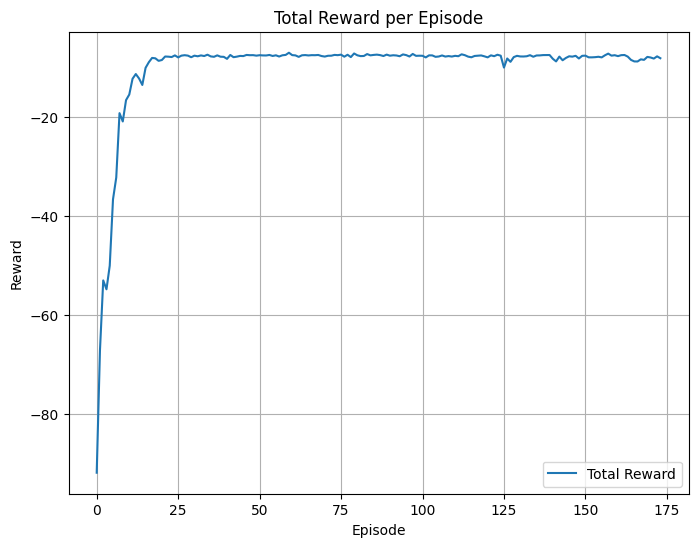

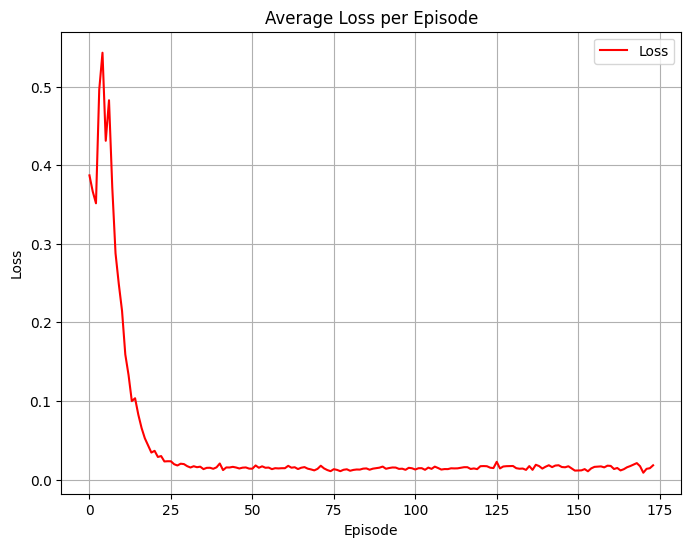

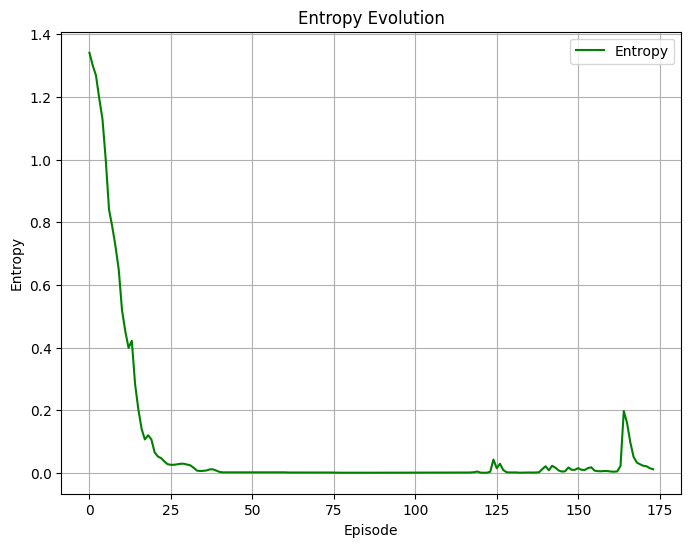

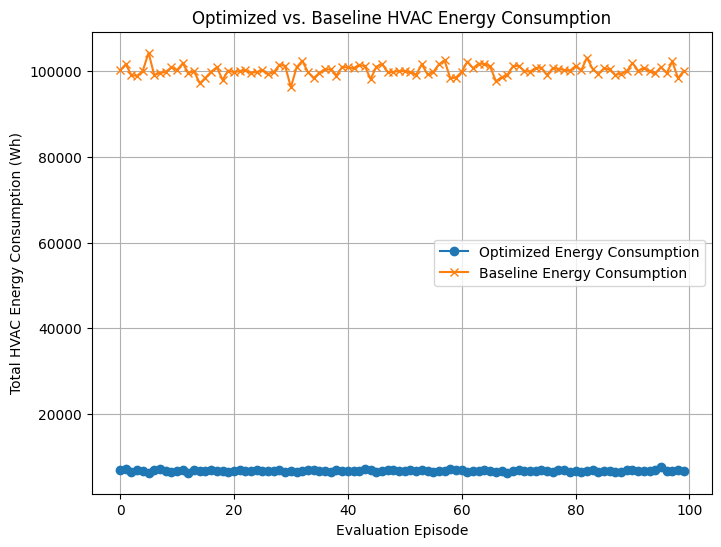

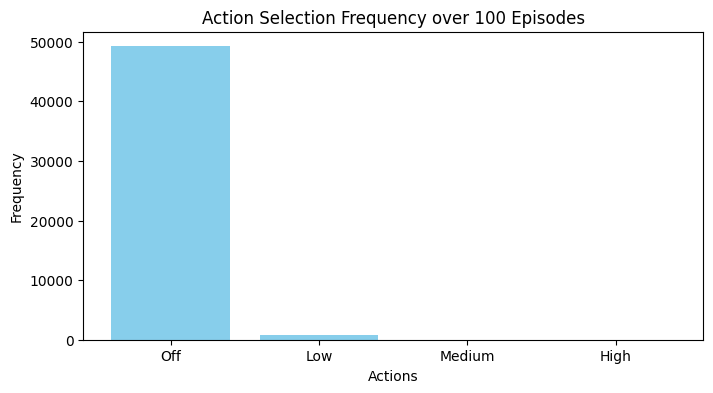

Action counts: [4.9218e+04 7.7500e+02 3.0000e+00 4.0000e+00]
Action probabilities: [9.8436e-01 1.5500e-02 6.0000e-05 8.0000e-05]


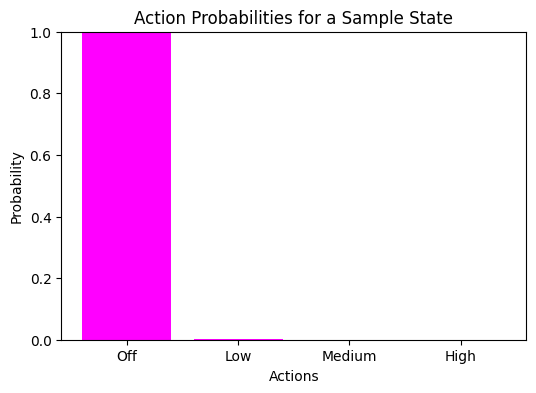

Sample State: [17.01703704  0.68333333  1.         21.         60.        ]
Action probabilities: [9.9918967e-01 8.0548588e-04 4.0602940e-06 8.3666094e-07]


In [ ]:
if __name__ == "__main__":
    # Load and Preprocess the Data 
    df = pd.read_csv("data/raw_data.csv")
    df = preprocess_data(df)
    
    # Data Split: 70% Train, 15% Test, 15% Validation 
    print("\nSplitting data into train, test, and validation sets...")
    train_data, temp_data = train_test_split(df, test_size=0.30, random_state=42)
    test_data, val_data = train_test_split(temp_data, test_size=0.50, random_state=42)
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Validation samples: {len(val_data)}")
    
    # Create Environments for each Data Split 
    env_train = HVACEnvironment(train_data, desired_temperature=22)
    env_test = HVACEnvironment(test_data, desired_temperature=22)
    env_val = HVACEnvironment(val_data, desired_temperature=22)
    
    # Initialize the PPO Agent 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_size = env_train.observation_space_shape
    action_size = env_train.action_space_n

    # Bayesian Optimization for Hyperparameter Tuning 
    print("\nStarting Bayesian Optimization for PPO Hyperparameters...")
    pbounds = {
        "actor_lr": (1e-5, 1e-3),
        "critic_lr": (1e-5, 1e-2),
        "clip_epsilon": (0.1, 0.3),
        "update_epochs": (2, 8)
    }
    
    def ppo_objective(actor_lr, critic_lr, clip_epsilon, update_epochs):
        update_epochs = int(round(update_epochs))
        ppo_agent = PPOAgent(state_size, action_size, device)
        ppo_agent.actor_lr = actor_lr
        ppo_agent.critic_lr = critic_lr
        ppo_agent.clip_epsilon = clip_epsilon
        ppo_agent.update_epochs = update_epochs
        ppo_agent.actor_optimizer = optim.Adam(ppo_agent.actor.parameters(), lr=actor_lr)
        ppo_agent.critic_optimizer = optim.Adam(ppo_agent.critic.parameters(), lr=critic_lr)
        
        # Run a tuning training session (
        tuning_episodes = 50
        rewards, _, _ = train_ppo(env_train, ppo_agent, env_val, n_episodes=tuning_episodes, max_t=500, cost_factor=0.10, patience=5)
        avg_reward = np.mean(rewards[-10:])  
        return avg_reward
    
    optimizer_bo = BayesianOptimization(
        f=ppo_objective,
        pbounds=pbounds,
        random_state=42,
    )
    optimizer_bo.maximize(init_points=5, n_iter=10)
    
    print("\nBest hyperparameters found:")
    print(optimizer_bo.max)
    
    # Retrain PPO with Best Hyperparameters 
    best_params = optimizer_bo.max["params"]
    best_params["update_epochs"] = int(round(best_params["update_epochs"]))
    best_agent = PPOAgent(state_size, action_size, device)
    best_agent.actor_lr = best_params["actor_lr"]
    best_agent.critic_lr = best_params["critic_lr"]
    best_agent.clip_epsilon = best_params["clip_epsilon"]
    best_agent.update_epochs = best_params["update_epochs"]
    best_agent.actor_optimizer = optim.Adam(best_agent.actor.parameters(), lr=best_params["actor_lr"])
    best_agent.critic_optimizer = optim.Adam(best_agent.critic.parameters(), lr=best_params["critic_lr"])
    
    print("\nTraining PPO on the full training split with optimized hyperparameters...")
    train_rewards, train_losses, entropy_vals = train_ppo(
        env_train, best_agent, env_val, n_episodes=10000, max_t=500, cost_factor=0.10, patience=100
    )
    
    # Save the trained model
    save_model_as_h5(best_agent, "/Users/amalshar/Desktop/USD/Spring 2025/Applied Reinforecement Learning/RL Project/exp2_ppo_model.h5")
    
    # Save training results to a JSON file
    results = {
        "rewards": train_rewards,
        "losses": train_losses,
        "entropy": entropy_vals
    }
    with open("/Users/amalshar/Desktop/USD/Spring 2025/Applied Reinforecement Learning/RL Project/exp2_results.json", "w") as f:
        json.dump(results, f)
    print("Training results saved to exp2_results.json")
    
    # Evaluate the Trained PPO Model 
    print("\nEvaluating PPO on the test split...")
    test_results = evaluate_ppo(env_test, best_agent, n_episodes=1000, max_t=500, C_energy=0.10)
    
    print("\nEvaluating PPO on the validation split...")
    val_results = evaluate_ppo(env_val, best_agent, n_episodes=1000, max_t=500, C_energy=0.10)
    
    # Extract total rewards from test_results
    test_rewards = [result["total_reward"] for result in test_results]
    
    # Plot Results 
    plot_training_results(train_rewards, train_losses, entropy_vals)
    
    optimized_energy = evaluate_energy_consumption(env_test, best_agent, n_episodes=100, max_t=500)
    baseline_energy = evaluate_baseline_energy(env_test, fixed_action=2, n_episodes=100, max_t=500)
    plot_energy_comparison(optimized_energy, baseline_energy)
    
    action_counts, action_probs = analyze_action_distribution(env_test, best_agent, n_episodes=100, max_t=500)
    print("Action counts:", action_counts)
    print("Action probabilities:", action_probs)
    visualize_policy_for_state(env_test, best_agent)